In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
#import statannot
from statannotations.Annotator import Annotator
import argparse
#import torch
import wandb
import sys
from functools import reduce
import torch
import math
import io
import colorcet as cc
import scipy
from adjustText import adjust_text
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset_Imgs, load_datasets, LabelConverter
#sys.path.append('./modified_medsam_repo')

# Init stuff

In [3]:
sns.set_style("whitegrid")
palette = sns.color_palette("Dark2")
palette2 = sns.color_palette("Paired")

In [4]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)

In [5]:
def beautify_region_names(x):
    x = x.replace('ctx-', 'Cortex ')
    
    x = x.replace('lh', 'Left')
    x = x.replace('rh', 'Right')
    x = x.replace('CC', 'Corpus Callosum')
    x = x.replace('isthmuscingulate', 'Isthmus Cingulate')
    x = x.replace('caudal', 'Caudal ')
    x = x.replace('rostral', 'Rostral ')
    x = x.replace('anterior', 'Anterior ')
    x = x.replace('posterior', 'Posterior ')
    

    x = x.replace('-', ' ')
    


# Load result files and create merged dataframe

In [6]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

def proc_pattern_for_eval_result_load(pattern):
    files = glob(pattern)
    listo = []
    for file in files:
        label_num = int(file.split('/')[-1].split('label')[1].split('.pkl')[0])
        
        #stuff = pd.read_pickle(file)
        with open(file, 'rb') as fileo:
            stuff = CPU_Unpickler(fileo).load()
        this_list = [label_num, stuff['dice_sensitivity'].item(), stuff['dice_specificity'].item(), stuff['overall_dice'].item()]
        this_arr = np.array(this_list).reshape((1, 4))
        listo.append(this_arr)

        

    combined = np.concatenate(listo, axis = 0)
    df = pd.DataFrame(combined, columns = ['label_number', 'dice_sensitivity', 'dice_specificity', 'overall_dice'])
    df = df.sort_values('label_number').reset_index(drop=True)

    return df

def load_and_make_into_df(path):
    df = pd.read_pickle(path)
    df = pd.DataFrame(df)
    df = df.rename({'label_numbers': 'label_number'}, axis=1)
    df = df.reset_index(drop=True)
    return df


In [7]:
singletask_unet = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/test/*/*/at_least_100/eval_singletask_unet_test_label*.pkl')
singletask_medsam = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM/test/*/*/at_least_100_pixels/*.pkl')
singletask_medsam_yolo = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_YOLO/test/*/0.0005/at_least_100_pixels/*.pkl')
singletask_medsam_oracle = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_Oracle/test/*/0.0005/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')
#singletask_unet = load_and_make_into_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/val/combined_at_least_100.pkl')
#singletask_medsam = load_and_make_into_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_dice_11-1-24/val/combined_at_least_100.pkl')
#singletask_medsam_yolo = load_and_make_into_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_yolo_retrain_dice_11-18-24/val/combined_at_least_100.pkl')

# fill in missing labels for singletask_medsam_yolo
dicto = {'dice_sensitivity':[np.nan]*4, 'dice_specificity':[1.0]*4, 'overall_dice':[np.nan]*4, 'label_number': [3,18,22,33]}
append_df = pd.DataFrame(dicto)
singletask_medsam_yolo = pd.concat([singletask_medsam_yolo, append_df], ignore_index=True)

In [ ]:
singletask_medsam_yolo.sort_values('dice_sensitivity')[-12:]

,label_number,dice_sensitivity,dice_specificity,overall_dice
5,7.0,0.927505,0.999678,0.992935
9,11.0,0.940126,0.999066,0.997989
10,12.0,0.944196,0.995309,0.983378
30,35.0,NaN,0.999240,0.999240
31,36.0,NaN,0.999962,0.999962
32,37.0,NaN,0.999926,0.999926
33,38.0,NaN,0.999963,0.999963
34,39.0,NaN,0.999849,0.999849
98,3.0,NaN,1.000000,NaN
99,18.0,NaN,1.000000,NaN


In [22]:
singletask_medsam.sort_values('dice_sensitivity')

,label_number,dice_sensitivity,dice_specificity,overall_dice
85,86.0,0.667588,0.999425,0.966123
58,59.0,0.683217,0.974658,0.960370
73,74.0,0.690151,0.968412,0.949000
89,90.0,0.692764,0.980806,0.964828
42,43.0,0.703128,0.978876,0.960559
...,...,...,...,...
34,35.0,NaN,0.997103,0.997103
35,36.0,NaN,0.996135,0.996135
36,37.0,NaN,0.996470,0.996470
37,38.0,NaN,0.970339,0.970339


In [21]:
singletask_medsam_yolo.sort_values('dice_sensitivity')[:15]
#labels = singletask_medsam_yolo.sort_values('dice_sensitivity').iloc[-9:-4, 0].values
#labels

,label_number,dice_sensitivity,dice_specificity,overall_dice
8,10.0,0.152840,1.000000,0.998987
35,40.0,0.609058,1.000000,0.999955
7,9.0,0.622945,0.999888,0.989085
85,90.0,0.624251,0.997517,0.976812
54,59.0,0.661290,0.997757,0.981262
69,74.0,0.707908,0.992908,0.973026
38,43.0,0.716892,0.994350,0.975920
77,82.0,0.725222,0.998255,0.974803
46,51.0,0.729824,0.997661,0.974629
48,53.0,0.744293,0.989477,0.946622


In [30]:
def rename_dfs(dict_of_dfs):
    for key in dict_of_dfs.keys():
        dfo = dict_of_dfs[key].copy()
        dfo = dfo.rename(
            {
                'dice_sensitivity': 'dice_sensitivity_' + key,
                'dice_specificity': 'dice_specificity_' + key,
                'overall_dice': 'overall_dice_' + key,
            }, 
            axis=1
        )

        dict_of_dfs[key] = dfo
    return dict_of_dfs
def merge_dict_of_dfs(dict_of_dfs):
    df_merged_wide = reduce(lambda left,right: pd.merge(left,right,on=['label_number'],
        how='outer', sort=True), list(dict_of_dfs.values()))

    # now make the long df
    col_list = ['label_number'] + [x for x in df_merged_wide.columns if x.startswith('dice_sensitivity')]
    tmp = df_merged_wide[col_list]
    df_merged_long = tmp.melt(id_vars = col_list[0], value_vars = col_list[1:],
        var_name = 'method', value_name = 'dice_score')
    df_merged_long['method'] = [x.split('dice_sensitivity_')[1] for x in df_merged_long['method']]

    return (df_merged_wide, df_merged_long)


# define df
dict_df = {'singletask_unet': singletask_unet, 'singletask_medsam': singletask_medsam, 
    'singletask_medsam_yolo': singletask_medsam_yolo, 'singletask_medsam_oracle': singletask_medsam_oracle}

# apply some steps before merging the dataframes
dict_df = rename_dfs(dict_df)
df_merged, df_long = merge_dict_of_dfs(dict_df)

# Plots

In [31]:
# set color scheme
my_colors = {'MedSAM-Constant': palette[0], 'MedSAM-YOLO': palette[1], 'UNet': palette[2], 'MedSAM-Oracle': palette[3], 
    'SAM-Constant': palette[5], 'SAM-YOLO': '#188ad6',
    'SAM-Oracle': '#1ca354'}

# make method names more readable
mapper = {
    'singletask_medsam_yolo': 'MedSAM-YOLO', 
    'singletask_medsam': 'MedSAM-Constant', 
    'singletask_medsam_oracle': 'MedSAM-Oracle',
    'singletask_unet': 'UNet',
    'singletask_sam': 'SAM-Constant',
    'singletask_sam_yolo': 'SAM-YOLO'
}

## Main Analysis

### Box-plot over all classes

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MedSAM-Constant vs. MedSAM-YOLO: t-test paired samples, P_val:5.278e-01 t=6.339e-01
MedSAM-YOLO vs. UNet: t-test paired samples, P_val:1.923e-07 t=-5.632e+00
MedSAM-Constant vs. UNet: t-test paired samples, P_val:2.066e-25 t=-1.446e+01


(<Axes: ylabel='Dice Score'>,
  <statannotations.Annotation.Annotation at 0x15545f9f72e0>])

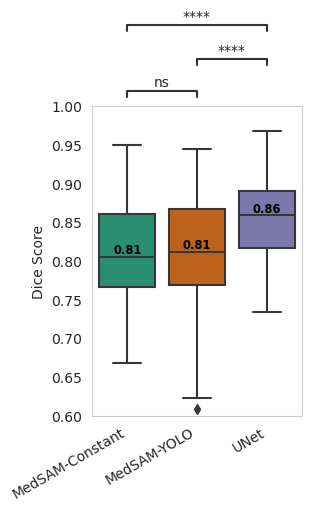

In [9]:
main_analysis_df = df_long.copy()

# figure
fig, axs = plt.subplots(constrained_layout=True, figsize = (3,5))

main_analysis_df['method'] = [mapper[x] for x in main_analysis_df['method']]

# set order
order = ['MedSAM-Constant', 'MedSAM-YOLO', 'UNet']

# subset
subdf = main_analysis_df[main_analysis_df['method'].isin(order)].reset_index(drop=True)

# plot
box_plot = sns.boxplot(data = subdf,
            x = 'method',
            y = 'dice_score',
            order = order,
            palette = my_colors,
            ax = axs
)
#axs.tick_params(axis='x', labelrotation=45)
for label_txt in box_plot.get_xticklabels():
    label_txt.set_rotation(30)  
    label_txt.set_ha('right')


medians = subdf.groupby('method')['dice_score'].median().reindex(index = order)
vertical_offset = .005 * subdf['dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'%s' % str('%.2f' % medians[xtick]), 
            horizontalalignment='center',size='small',color='black',weight='semibold')
axs.grid(False)


axs.set_ylabel('Dice Score')
#axs.set_xlabel('Method')
axs.set_xlabel('')
# add statistical tests
annotator = Annotator(axs, 
    pairs = [
        (order[0], order[1]),
        (order[0], order[2]),
        (order[1], order[2])
    ], 
    data=subdf, 
    x='method', 
    y='dice_score', 
    order=order
)
axs.set_ylim(0.6,1)

annotator.configure(test='t-test_paired', text_format='star', loc='outside')
annotator.apply_and_annotate()  

#fig.savefig('/gpfs/home/kn2347/figs/main_analysis_boxplot.pdf', dpi=300)

### Crossplot

In [88]:
plotdf = df_merged[['label_number', 'dice_sensitivity_singletask_unet', 'dice_sensitivity_singletask_medsam']].copy()
plotdf['label_number'] = [label_converter.compressed_to_name(x).item() for x in plotdf['label_number']]
label_info = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/label_info.csv')
plotdf = plotdf.merge(label_info, how='left', on='label_number') # now has side, name_without_side, group

In [28]:
plotdf[plotdf.dice_sensitivity_singletask_unet <= plotdf.dice_sensitivity_singletask_medsam	]

,label_number,dice_sensitivity_singletask_unet,dice_sensitivity_singletask_medsam,name_without_side,side,group
8,Left-Pallidum,0.733881,0.766003,Pallidum,Left,Subcortex
39,CC_Anterior,0.890122,0.900216,CC_Anterior,Neither,Corpus-Callosum


     label_number  dice_sensitivity_singletask_unet  \
8   Left-Pallidum                          0.733881   
39    CC_Anterior                          0.890122   

    dice_sensitivity_singletask_medsam name_without_side     side  \
8                             0.766003          Pallidum     Left   
39                            0.900216       CC_Anterior  Neither   

              group  
8         Subcortex  
39  Corpus-Callosum  


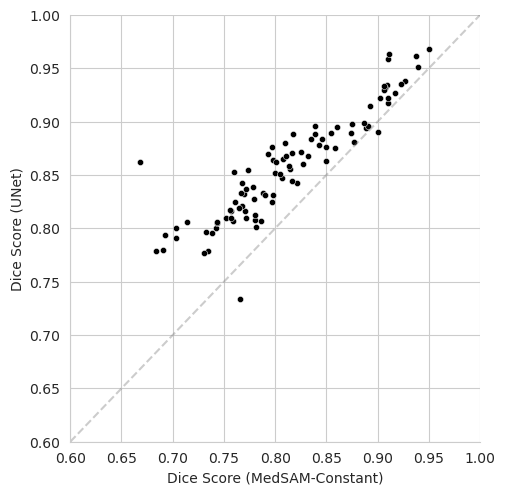

In [89]:
plotdf = df_merged[['label_number', 'dice_sensitivity_singletask_unet', 'dice_sensitivity_singletask_medsam']].copy()
plotdf['label_number'] = [label_converter.compressed_to_name(x).item() for x in plotdf['label_number']]
label_info = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/label_info.csv')
plotdf = plotdf.merge(label_info, how='left', on='label_number') # now has side, name_without_side, group

print(plotdf[plotdf.dice_sensitivity_singletask_unet <= plotdf.dice_sensitivity_singletask_medsam])

myplot = sns.relplot(plotdf, x = 'dice_sensitivity_singletask_medsam', y = 'dice_sensitivity_singletask_unet', s=20, color='black')
plt.xlim(0.6,1)
plt.ylim(0.6,1)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (MedSAM-Constant)')
plt.ylabel('Dice Score (UNet)')
'''
texts = [plt.text(
    plotdf.loc[i, 'dice_sensitivity_singletask_medsam'], 
    plotdf.loc[i, 'dice_sensitivity_singletask_unet'],
    plotdf.loc[i, 'name_without_side'], ha='center', va='center', size=5) for i in range(len(plotdf))
]
'''
plt.savefig('/gpfs/home/kn2347/figs/unet_medsam_crossplot.pdf', dpi=300)

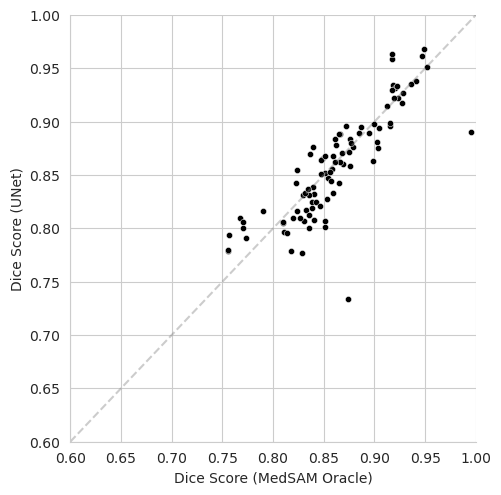

In [32]:
plotdf = df_merged[['label_number', 'dice_sensitivity_singletask_unet', 'dice_sensitivity_singletask_medsam_oracle']].copy()
plotdf['label_number'] = [label_converter.compressed_to_name(x).item() for x in plotdf['label_number']]
label_info = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/label_info.csv')
plotdf = plotdf.merge(label_info, how='left', on='label_number') # now has side, name_without_side, group

myplot = sns.relplot(plotdf, x = 'dice_sensitivity_singletask_medsam_oracle', y = 'dice_sensitivity_singletask_unet', s=20, color='black')
plt.xlim(0.6,1)
plt.ylim(0.6,1)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (MedSAM Oracle)')
plt.ylabel('Dice Score (UNet)')
plt.savefig('/gpfs/home/kn2347/figs/unet_medsam_oracle_crossplot.pdf', dpi=300)

### Per-class performance

In [50]:
order_descending = df_long.dropna(how='all').groupby('label_number').agg({'dice_score':'median'}).sort_values('dice_score', ascending=False).dropna().index.astype(int).tolist()
order_descending = [label_converter.compressed_to_name(x).item() for x in order_descending]
order_descending

['3rd-Ventricle',
 'Brain-Stem',
 '4th-Ventricle',
 'Left-Caudate',
 'Right-Caudate',
 'Right-Thalamus-Proper',
 'Right-Cerebellum-Cortex',
 'Right-Putamen',
 'Left-Cerebellum-Cortex',
 'Left-Cerebral-White-Matter',
 'Right-Cerebral-White-Matter',
 'Left-Lateral-Ventricle',
 'Left-Thalamus-Proper',
 'Right-Hippocampus',
 'Right-Lateral-Ventricle',
 'Left-Hippocampus',
 'CC_Anterior',
 'Left-Amygdala',
 'Right-Amygdala',
 'Left-Putamen',
 'Right-VentralDC',
 'Left-VentralDC',
 'Left-Accumbens-area',
 'Left-Cerebellum-White-Matter',
 'Right-Cerebellum-White-Matter',
 'Right-Pallidum',
 'Right-Accumbens-area',
 'ctx-rh-superiorfrontal',
 'ctx-lh-superiorfrontal',
 'CSF',
 'ctx-lh-precentral',
 'ctx-lh-insula',
 'ctx-lh-lateralorbitofrontal',
 'ctx-rh-precentral',
 'ctx-lh-rostralmiddlefrontal',
 'ctx-rh-lateralorbitofrontal',
 'ctx-lh-paracentral',
 'ctx-rh-caudalanteriorcingulate',
 'ctx-rh-rostralmiddlefrontal',
 'ctx-rh-insula',
 'ctx-rh-superiortemporal',
 'ctx-rh-transversetemporal',

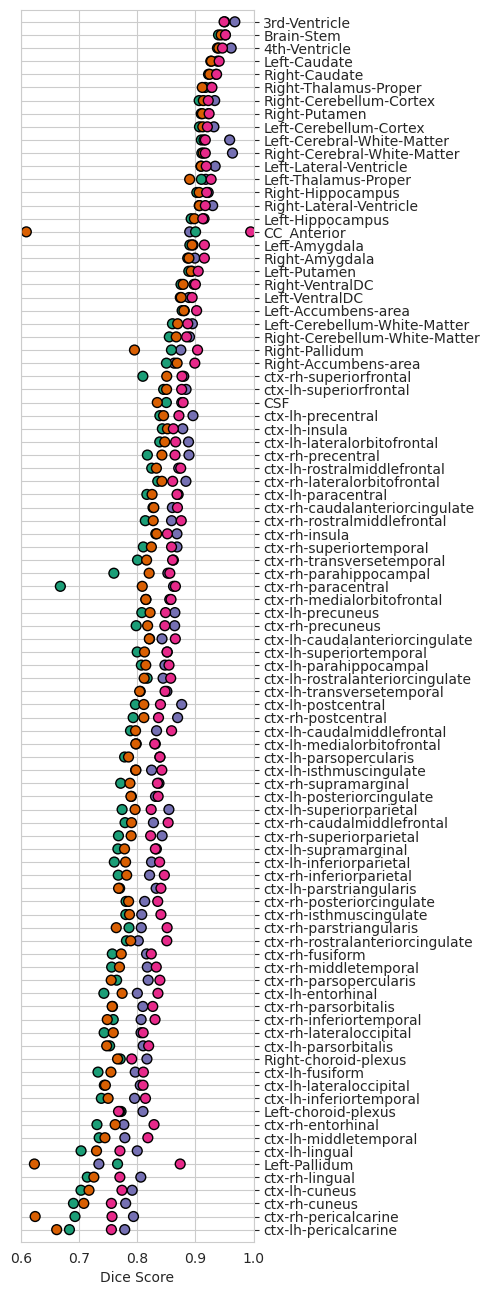

In [12]:
groups = 1
tot = 102
per = math.ceil(tot / groups)
fig, axs = plt.subplots(figsize = (3, 16))
for idx in range(groups):
    idx_L = per * (idx)
    idx_R = per * (idx+1) - 1

    sub2 = df_long.copy() 
    sub2['label_number'] = [label_converter.compressed_to_name(x).item() for x in sub2['label_number']]
    sub2 = sub2.set_index('label_number').loc[order_descending[idx_L:idx_R],:].reset_index(drop=False)
    sub2['method'] = [mapper[x] for x in sub2['method']]
    sub2['label_number'] = pd.Categorical(sub2['label_number'], categories=order_descending[idx_L:idx_R], ordered=True)
    #sub2 = sub2[sub2['label_number'].isin(order_descending[idx_L : idx_R])]
    
    

    
    #fig, axs = plt.subplots(constrained_layout=True, figsize = (4 * 4 / groups, 3))
    
    #sub2 = sub2[sub2['label_number'] <= 5]
    sub2 = sub2.dropna(axis=0, how='any')
    _ = sns.scatterplot(sub2, x='dice_score', y='label_number', hue='method', ax = axs, 
        s=50, edgecolor = 'black', linewidth=1, legend=None, marker='o', palette=my_colors, alpha=1) # make points translucent

    axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), ha='left')
    axs.yaxis.set_label_position("right")
    axs.yaxis.tick_right()
    axs.set_xlabel('Dice Score')
    axs.set_ylabel('')
    axs.margins(y=0.01) 
    axs.set_xlim(0.6, 1.0)
#fig.savefig('/gpfs/home/kn2347/figs/main_analysis_strip_plot.pdf', dpi=300, bbox_inches = 'tight')


### Plots by group

In [15]:
subcortical = ['Left-Caudate', 'Left-Putamen', 'Right-Caudate', 'Right-Putamen', 'Left-Pallidum', 'Right-Pallidum', 'Brain-Stem',
        'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'Left-VentralDC',
        'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
        'Left-Thalamus-Proper', 'Right-Thalamus-Proper']
wm = ['Left-Cerebral-White-Matter', 'Right-Cerebral-White-Matter', 
    'Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter', 'Optic-Chiasm',
    'CC_Anterior',
    'CC_Central',
    'CC_Mid_Anterior',
    'CC_Mid_Posterior',
    'CC_Posterior']

cortical = ['Left-Cerebellum-Cortex',
    'Right-Cerebellum-Cortex', 'ctx-lh-caudalanteriorcingulate', 'ctx-lh-caudalmiddlefrontal', 'ctx-lh-cuneus',
    'ctx-lh-entorhinal', 'ctx-lh-fusiform', 'ctx-lh-inferiorparietal', 'ctx-lh-inferiortemporal',
    'ctx-lh-isthmuscingulate', 'ctx-lh-lateraloccipital', 'ctx-lh-lateralorbitofrontal', 'ctx-lh-lingual',
    'ctx-lh-medialorbitofrontal', 'ctx-lh-middletemporal', 'ctx-lh-parahippocampal', 'ctx-lh-paracentral',
    'ctx-lh-parsopercularis', 'ctx-lh-parsorbitalis', 'ctx-lh-parstriangularis', 'ctx-lh-pericalcarine',
    'ctx-lh-postcentral', 'ctx-lh-posteriorcingulate', 'ctx-lh-precentral', 'ctx-lh-precuneus',
    'ctx-lh-rostralanteriorcingulate', 'ctx-lh-rostralmiddlefrontal', 'ctx-lh-superiorfrontal', 'ctx-lh-superiorparietal',
    'ctx-lh-superiortemporal', 'ctx-lh-supramarginal', 'ctx-lh-transversetemporal', 'ctx-lh-insula',
    'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus', 'ctx-rh-entorhinal',
    'ctx-rh-fusiform', 'ctx-rh-inferiorparietal', 'ctx-rh-inferiortemporal', 'ctx-rh-isthmuscingulate',
    'ctx-rh-lateraloccipital', 'ctx-rh-lateralorbitofrontal', 'ctx-rh-lingual', 'ctx-rh-medialorbitofrontal',
    'ctx-rh-middletemporal', 'ctx-rh-parahippocampal', 'ctx-rh-paracentral', 'ctx-rh-parsopercularis',
    'ctx-rh-parsorbitalis', 'ctx-rh-parstriangularis', 'ctx-rh-pericalcarine', 'ctx-rh-postcentral',
    'ctx-rh-posteriorcingulate', 'ctx-rh-precentral', 'ctx-rh-precuneus', 'ctx-rh-rostralanteriorcingulate',
    'ctx-rh-rostralmiddlefrontal', 'ctx-rh-superiorfrontal', 'ctx-rh-superiorparietal', 'ctx-rh-superiortemporal',
    'ctx-rh-supramarginal', 'ctx-rh-transversetemporal', 'ctx-rh-insula'
]

ventricular_or_vessel = [
    '3rd-Ventricle',
    '4th-Ventricle',
    'CSF',
    'Left-Inf-Lat-Vent',
    'Left-Lateral-Ventricle',
    'Left-vessel',
    'Right-Inf-Lat-Vent',
    'Right-Lateral-Ventricle',
    'Right-vessel',
    'Left-choroid-plexus', 'Right-choroid-plexus'
]

groups = [wm, cortical, subcortical, ventricular_or_vessel]

def generate_color_map(seed = 2023):
    
    np.random.seed(2023)
    rand_nums = np.random.random((103, 3))
    color_label_mapper = dict()
    for i in range(103):
        color_label_mapper[i] = (rand_nums[i, :] * 255).astype('uint8')
    return color_label_mapper

color_label_mapper = generate_color_map(seed = 2023)

### Strip Plot

               label_number           method  dice_score
0             3rd-Ventricle             UNet    0.967814
1             3rd-Ventricle  MedSAM-Constant    0.950321
2             4th-Ventricle             UNet    0.961490
3             4th-Ventricle  MedSAM-Constant    0.937871
4    Left-Lateral-Ventricle             UNet    0.933938
5    Left-Lateral-Ventricle  MedSAM-Constant    0.909373
6   Right-Lateral-Ventricle             UNet    0.929654
7   Right-Lateral-Ventricle  MedSAM-Constant    0.906551
8                       CSF             UNet    0.876435
9                       CSF  MedSAM-Constant    0.850031
10     Right-choroid-plexus             UNet    0.816564
11     Right-choroid-plexus  MedSAM-Constant    0.770630
12      Left-choroid-plexus             UNet    0.809745
13      Left-choroid-plexus  MedSAM-Constant    0.772030


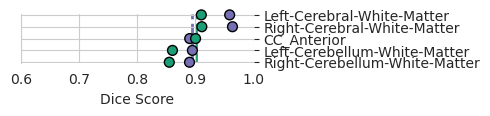

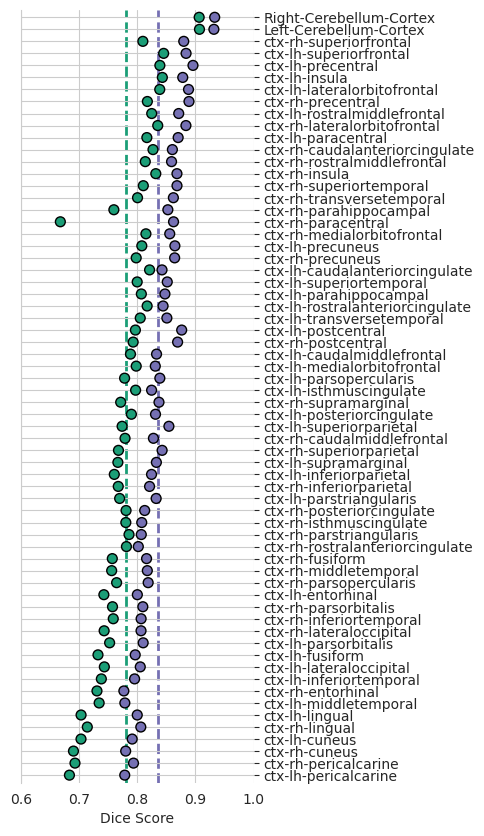

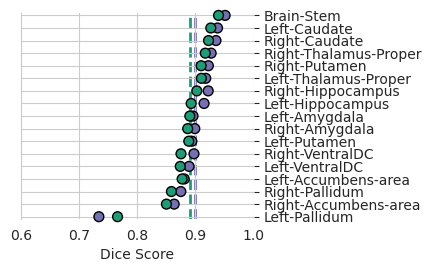

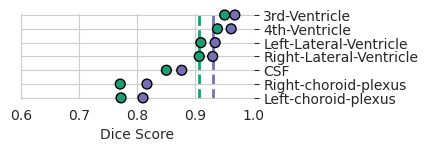

In [55]:

for ii, grp in enumerate(groups):
    
    #idx_L = per * (idx)
    #idx_R = per * (idx+1) - 1

    sub2 = df_long.copy() 
    sub2 = sub2[sub2['method'].isin(['singletask_medsam', 'singletask_unet'])].reset_index(drop=True)
    #sub2 = sub2[sub2['method'] != 'singletask_medsam_yolo'].reset_index(drop=True) # exclude medsam yolo
    sub2['label_number'] = [label_converter.compressed_to_name(x).item() for x in sub2['label_number']]
    sub2 = sub2[sub2['label_number'].isin(grp)]
    order_descending_for_this_group = [x for x in order_descending if x in grp]
    sub2 = sub2.set_index('label_number').loc[order_descending_for_this_group,:].reset_index(drop=False)

    num = len(sub2)
    if ii == 0:
        num = 4 * 2
    elif ii==3:
        num = 7 * 2
    fig, axs = plt.subplots(figsize = (3, 16*num/102/2))

    #sub2 = sub2.set_index('label_number').loc[[idx_L:idx_R],:].reset_index(drop=False)
    sub2['method'] = [mapper[x] for x in sub2['method']]
    sub2['label_number'] = pd.Categorical(sub2['label_number'], categories=order_descending_for_this_group, ordered=True)


    #sub2 = sub2[sub2['label_number'].isin(order_descending[idx_L : idx_R])]
    
    
    if(len(sub2) > 4):
        method_medians = sub2.groupby('method').agg({'dice_score':'median'})
        for r in method_medians.iterrows():
            # add vertical line with value equal to this dice score, and hue equal to the method indexed in my_colors
            axs.axvline(x = r[1].values[0], color = my_colors[r[0]], linestyle = '--', alpha = 1, linewidth=2, zorder=0)

    if ii == 3:
        print(sub2)

    
    #fig, axs = plt.subplots(constrained_layout=True, figsize = (4 * 4 / groups, 3))
    
    #sub2 = sub2[sub2['label_number'] <= 5]
    sub2 = sub2.dropna(axis=0, how='any')
    _ = sns.scatterplot(sub2, x='dice_score', y='label_number', hue='method', ax = axs, 
        s=50, edgecolor = 'black', linewidth=1, legend=None, marker='o', palette=my_colors, alpha=1, clip_on=False) # make points translucent

    axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), ha='left')
    axs.yaxis.set_label_position("right")
    axs.yaxis.tick_right()
    axs.set_xlabel('Dice Score')
    axs.set_ylabel('')
    axs.margins(y=0.01) 
    axs.set_xlim(0.6, 1.0)

    #axs.set_frame_on(False)
    axs.spines[['right', 'top', 'bottom']].set_visible(False)
    fig.savefig(f'/gpfs/home/kn2347/figs/strip_plot_components/{ii}.pdf', dpi=300, bbox_inches = 'tight')
    
#fig.savefig('/gpfs/home/kn2347/figs/main_analysis_strip_plot.pdf', dpi=300, bbox_inches = 'tight')


In [ ]:
order_descending_by_group = [x for grp in groups for x in order_descending if x in grp]
order_descending_by_group

(0.6, 1.0)

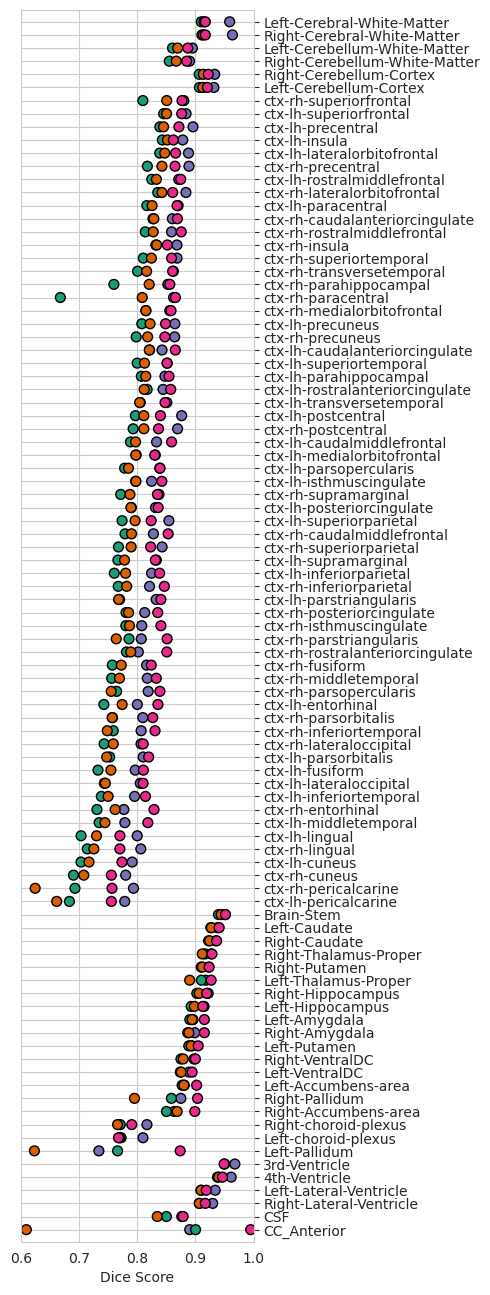

In [67]:
# another viz
tot = 102
fig, axs = plt.subplots(figsize = (3, 16))

order_descending_by_group = [x for grp in groups for x in order_descending if x in grp]


sub2 = df_long.copy() 
sub2['label_number'] = [label_converter.compressed_to_name(x).item() for x in sub2['label_number']]
sub2 = sub2.set_index('label_number').loc[order_descending_by_group,:].reset_index(drop=False)
sub2['method'] = [mapper[x] for x in sub2['method']]
sub2['label_number'] = pd.Categorical(sub2['label_number'], categories=order_descending_by_group, ordered=True)
#sub2 = sub2[sub2['label_number'].isin(order_descending[idx_L : idx_R])]




#fig, axs = plt.subplots(constrained_layout=True, figsize = (4 * 4 / groups, 3))

#sub2 = sub2[sub2['label_number'] <= 5]
sub2 = sub2.dropna(axis=0, how='any')
_ = sns.scatterplot(sub2, x='dice_score', y='label_number', hue='method', ax = axs, 
    s=50, edgecolor = 'black', linewidth=1, legend=None, marker='o', palette=my_colors, alpha=1) # make points translucent

axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), ha='left')
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('Dice Score')
axs.set_ylabel('')
axs.margins(y=0.01) 
axs.set_xlim(0.6, 1.0)
#fig.savefig('/gpfs/home/kn2347/figs/main_analysis_strip_plot.pdf', dpi=300, bbox_inches = 'tight')


### Grouped plot

In [86]:
all_regions = wm + cortical + subcortical + ventricular_or_vessel + cc_regions
group_list = ['White-Matter']*len(wm) + ['Cortex']*len(cortical) + ['Subcortex']*len(subcortical) + ['Ventricle_or_Vessel']*len(ventricular_or_vessel) + ['Corpus-Callosum']*len(cc_regions)

def get_hemisphere(region_name):
    if 'lh' in region_name or 'Left' in region_name:
        return 'Left'
    elif 'rh' in region_name or 'Right' in region_name:
        return 'Right'
    else:
        return 'Neither'
def name_without_hemisphere(region_name):
    try_list = ['lh-', 'rh-', 'Left-', 'Right-']
    
    for try_elem in try_list:
        if try_elem in region_name:
            return region_name.replace(try_elem, '')

    # if here, does not have side information
    return region_name

side_list = [get_hemisphere(x) for x in all_regions]
names_without_side = [name_without_hemisphere(x) for x in all_regions]

label_info = pd.DataFrame({'label_number': all_regions, 'name_without_side': names_without_side, 'side': side_list, 'group': group_list})
label_info.to_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/label_info.csv', index=False)

/tmp/ipykernel_2038443/2001165474.py:29: UserWarning: The palette list has more values (64) than needed (4), which may not be intended.
  sns.stripplot(subsub, x='method', y='dice_score', hue='label_number', legend=None, size=5, linewidth=1,
/tmp/ipykernel_2038443/2001165474.py:29: UserWarning: The palette list has more values (64) than needed (19), which may not be intended.
  sns.stripplot(subsub, x='method', y='dice_score', hue='label_number', legend=None, size=5, linewidth=1,
/tmp/ipykernel_2038443/2001165474.py:29: UserWarning: The palette list has more values (64) than needed (5), which may not be intended.
  sns.stripplot(subsub, x='method', y='dice_score', hue='label_number', legend=None, size=5, linewidth=1,


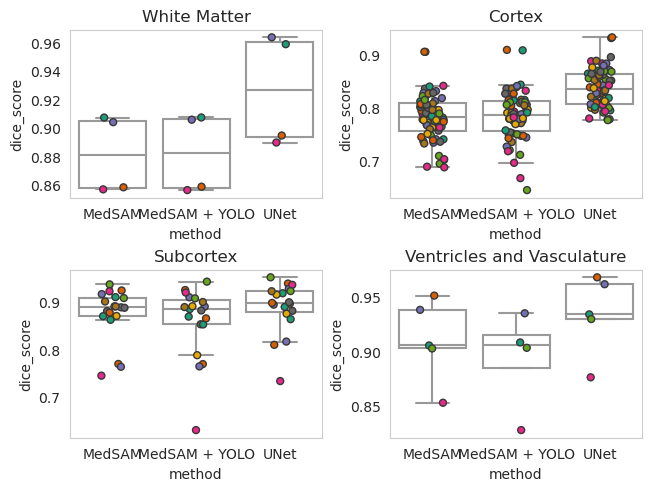

In [ ]:
this_pal = sns.color_palette("Dark2", 64)

df_per_group = main_analysis_df.copy()
df_per_group['label_number'] = [label_converter.compressed_to_name(x).item() for x in df_per_group['label_number']]
order = ['MedSAM', 'MedSAM + YOLO', 'UNet']

r = 2
c = 2
fig, axs = plt.subplots(r, c, constrained_layout=True, squeeze=False)

this_pal = sns.color_palette("Dark2", 64)
for idx, (grp, name) in enumerate(zip(groups, ['White Matter', 'Cortex', 'Subcortex', 'Ventricles and Vasculature'])):
    i = idx // c
    j = idx % c
    subsub = df_per_group[df_per_group['label_number'].isin(grp)].reset_index(drop=True)
    subsub = subsub.merge(label_info, how='left', on='label_number') # now has side, name_without_side, group
    subsub = subsub[subsub['dice_score'] >= 0.5].reset_index(drop=True)

    # create a color palette to use
    unq_names = np.unique(subsub['name_without_side']).tolist()
    dicto = {}
    this_palette = sns.color_palette(cc.glasbey, n_colors=len(unq_names))
    for idxx, zz in enumerate(unq_names):
        dicto[zz] = this_palette[idxx]

    sns.boxplot(subsub, x='method', y='dice_score', palette=['white'] * subsub['method'].nunique(),
        order = order, ax = axs[i,j], showfliers=False)
    
    sns.stripplot(subsub, x='method', y='dice_score', hue='label_number', legend=None, size=5, linewidth=1,
        order=order, jitter = 0.15, ax = axs[i,j], palette = this_pal)

    axs[i,j].set_title(name)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MedSAM vs. MedSAM + YOLO: t-test paired samples, P_val:4.381e-01 t=-8.919e-01
MedSAM + YOLO vs. UNet: t-test paired samples, P_val:4.864e-03 t=-7.525e+00
MedSAM vs. UNet: t-test paired samples, P_val:5.618e-03 t=-7.157e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MedSAM vs. MedSAM + YOLO: t-test paired samples, P_val:6.863e-02 t=-1.853e+00
MedSAM + YOLO vs. UNet: t-test paired samples, P_val:4.280e-29 t=-2.010e+01
MedSAM vs. UNet: t-test paired samples, P_val:1.863e-32 t=-2.310e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
   

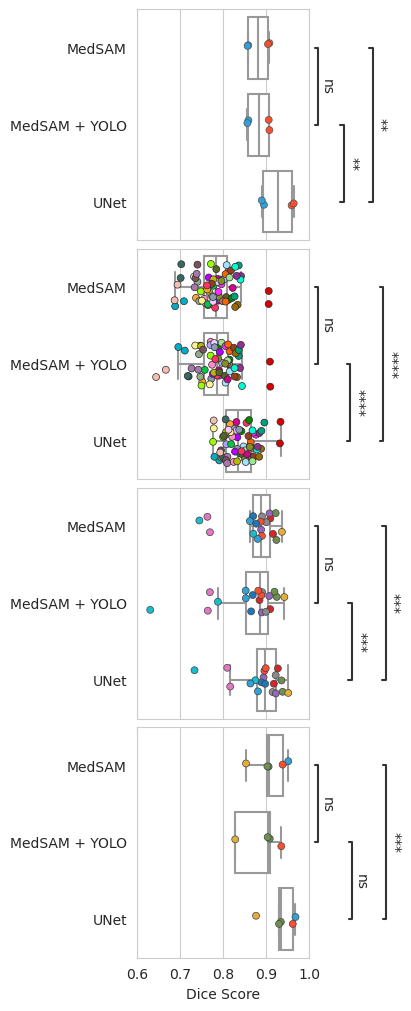

In [312]:

df_per_group = main_analysis_df.copy()
df_per_group['label_number'] = [label_converter.compressed_to_name(x).item() for x in df_per_group['label_number']]
order = ['MedSAM', 'MedSAM + YOLO', 'UNet']

r = 4
c = 1
fig, axs = plt.subplots(r, c, constrained_layout=True, squeeze=False, sharey=True, sharex=True, figsize = (4, 10))

jitters = [0.075, 0.3, 0.2, 0.075]
palettes = [cc.glasbey_hv, cc.glasbey_light, cc.glasbey_hv, cc.glasbey_hv]

for idx, (grp, name) in enumerate(zip(groups, ['White Matter', 'Cortex', 'Subcortex', 'Ventricles and Vasculature'])):
    i = idx // c
    j = idx % c
    subsub = df_per_group[df_per_group['label_number'].isin(grp)].reset_index(drop=True)
    subsub = subsub.merge(label_info, how='left', on='label_number') # now has side, name_without_side, group
    subsub = subsub[subsub['dice_score'] >= 0.01].reset_index(drop=True)

    # create a color palette to use
    unq_names = np.unique(subsub['name_without_side']).tolist()
    dicto = {}
    #this_palette = sns.color_palette(cc.glasbey, n_colors=len(unq_names))
    this_palette = sns.color_palette(palettes[idx], n_colors=len(unq_names))
    for idxx, zz in enumerate(unq_names):
        dicto[zz] = this_palette[idxx]


    subsub['method'] = pd.Categorical(subsub['method'], categories = order, ordered = True)

    sns.boxplot(subsub, y='method', x='dice_score', palette=['white'] * subsub['method'].nunique(),
        ax = axs[i,j], showfliers=False)

    sns.stripplot(subsub, y='method', x='dice_score', hue='name_without_side', legend=None, size=5, linewidth=0.5, 
        jitter = jitters[idx], ax = axs[i,j], palette = dicto)

    if idx == r*c-1:
        axs[i,j].set_xlabel('Dice Score')
    else:
        axs[i,j].set_xlabel('')
    axs[i,j].set_ylabel('')

    # add statistical tests
    annotator = Annotator(axs[i,j], 
        pairs = [
            (order[0], order[1]),
            (order[1], order[2]),
            (order[0], order[2])
        ], 
        data=subsub, 
        x='dice_score', 
        y='method', 
        order=order,
        orient='h'
    )
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')

    axs[i,j].set_xlim(0.6, 1)
    annotator.apply_and_annotate()  

fig.savefig('/gpfs/home/kn2347/figs/main_analysis_grouped.pdf', dpi=300)
    

    #axs[i,j].set_xticks(order, order, rotation=90, ha='right', fontsize=9)

    #sns.swarmplot(subsub, x='method', y='dice_score', hue='name_without_side', legend=None, size=5, linewidth=1,
    #    ax = axs[i,j], palette = dicto)

    #axs[i,j].set_title(name)

### Contributors to Model Performance Analysis

In [13]:
# First, load in the necessary data

class_statistics = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/training_set_class_statistics_10-15-24/class_statistics.csv')
class_contrasts = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/class_contrasts_12-30-24/using_50_mris.csv')

# rename columns e.g. median -> contrast_median
class_contrasts = class_contrasts.rename({x: 'contrast_' + x for x in class_contrasts.columns if x != 'label'}, axis=1)

# Merge class_statistics and class_contrasts using the label column
class_info = pd.merge(class_statistics, class_contrasts, on='label', how='inner')

In [15]:
class_info

,label,total_slices,total_pixels,avg_pixels_per_slice_when_present,avg_pixels_per_all_slices,fraction_slices_present,contrast_median,contrast_ci5,contrast_ci95
0,1,97036.0,196034640.0,2020.225896,859.439184,0.425417,0.305275,0.233013,0.362900
1,2,26060.0,5570108.0,213.741673,24.420016,0.114250,0.566297,0.380451,0.655262
2,3,12236.0,177081.0,14.472131,0.776344,0.053644,0.414001,0.267896,0.534963
3,4,38779.0,12517295.0,322.785399,54.877310,0.170012,0.196934,0.114628,0.291474
4,5,54601.0,50639640.0,927.448948,222.010206,0.239377,0.253805,0.053328,0.953601
...,...,...,...,...,...,...,...,...,...
97,98,50700.0,12439773.0,245.360414,54.537445,0.222275,0.074961,0.006244,0.483958
98,99,48432.0,11177503.0,230.787558,49.003503,0.212332,0.068937,0.006073,0.224300
99,100,37867.0,9831934.0,259.643859,43.104368,0.166013,0.059677,0.005386,0.579900
100,101,14903.0,948821.0,63.666443,4.159744,0.065337,0.048715,0.004485,0.174680


In [38]:
def modify_df(dfo):
    # match subdf using label_number with class_info using label
    dfo['label_number'] = dfo['label_number'].astype(int)
    covariates_matrix = pd.merge(dfo, class_info, left_on='label_number', right_on='label', how='inner')
    covariates_matrix = covariates_matrix.drop('label', axis=1)

    # drop rows where dice_score is NaN
    covariates_matrix = covariates_matrix.dropna(subset=['dice_score']).reset_index(drop=True)

    # drop some columns which are already correlated
    drop_cols = ['avg_pixels_per_all_slices', 'fraction_slices_present']
    covariates_matrix = covariates_matrix.drop(drop_cols, axis=1)
    return covariates_matrix

def print_correlations(dfo):
    # get the columns that are not label, method, or dice_score
    cols_to_test = [x for x in dfo.columns if x not in ['label_number', 'method', 'dice_score']]
    correlation_dict = {}
    p_value_dict = {}
    for col in cols_to_test:
        corr, p_val = scipy.stats.pearsonr(dfo[col], dfo['dice_score'])
        correlation_dict[col] = corr
        #p_val = p_val # bonferroni correction
        p_value_dict[col] = p_val

        print(f'{col}: correlation = {corr}, p-value = {p_val}')

#### Model performance (combining UNet and MedSAM)

In [39]:
subdf = df_long[df_long['method'].isin(['singletask_unet', 'singletask_medsam'])].reset_index(drop=True)
combined_model_performance_covariates_matrix = modify_df(subdf)
print_correlations(combined_model_performance_covariates_matrix)

total_slices: correlation = 0.1404299686279991, p-value = 0.0559040530708301
total_pixels: correlation = 0.2748283124584904, p-value = 0.00014689907464327374
avg_pixels_per_slice_when_present: correlation = 0.2960629699983536, p-value = 4.0799681074709e-05
contrast_median: correlation = 0.5197847370102808, p-value = 2.904567286779292e-14
contrast_ci5: correlation = 0.49604958075899086, p-value = 6.042843526343262e-13
contrast_ci95: correlation = 0.18995337039750798, p-value = 0.00940853225279806


#### UNet - MedSAM difference

In [44]:
# difference between UNet dice_sensitivity and MedSAM dice_sensitivity; name this column 'dice_score'
# drop all other columns besides label_number
subdf = df_merged[['label_number', 'dice_sensitivity_singletask_unet', 'dice_sensitivity_singletask_medsam']].copy()
subdf['dice_score'] = subdf['dice_sensitivity_singletask_unet'] - subdf['dice_sensitivity_singletask_medsam']
subdf = subdf.drop(['dice_sensitivity_singletask_unet', 'dice_sensitivity_singletask_medsam'], axis=1)
difference_models_performance_covariates_matrix = modify_df(subdf)
print_correlations(difference_models_performance_covariates_matrix)

total_slices: correlation = 0.2672844621417904, p-value = 0.009596449750002714
total_pixels: correlation = 0.042484197753096725, p-value = 0.6859595580004749
avg_pixels_per_slice_when_present: correlation = 0.02630900048712107, p-value = 0.8023347011581112
contrast_median: correlation = -0.25444310539479126, p-value = 0.013846308140087542
contrast_ci5: correlation = -0.22072489424720282, p-value = 0.03349472826027082
contrast_ci95: correlation = 0.051548299401050435, p-value = 0.6236266746967603


### Viz class contrasts


In [46]:
class_contrasts = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/class_contrasts_12-30-24/using_50_mris.csv')
# add the label name
class_contrasts['label'] = [label_converter.compressed_to_name(x).item() for x in class_contrasts['label']]
class_contrasts



,label,median,ci5,ci95
0,Left-Cerebral-White-Matter,0.305275,0.233013,0.362900
1,Left-Lateral-Ventricle,0.566297,0.380451,0.655262
2,Left-Inf-Lat-Vent,0.414001,0.267896,0.534963
3,Left-Cerebellum-White-Matter,0.196934,0.114628,0.291474
4,Left-Cerebellum-Cortex,0.253805,0.053328,0.953601
...,...,...,...,...
97,ctx-rh-superiorparietal,0.074961,0.006244,0.483958
98,ctx-rh-superiortemporal,0.068937,0.006073,0.224300
99,ctx-rh-supramarginal,0.059677,0.005386,0.579900
100,ctx-rh-transversetemporal,0.048715,0.004485,0.174680


/tmp/ipykernel_1706135/648602495.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


TypeError: Axes.errorbar() got multiple values for argument 'ax'

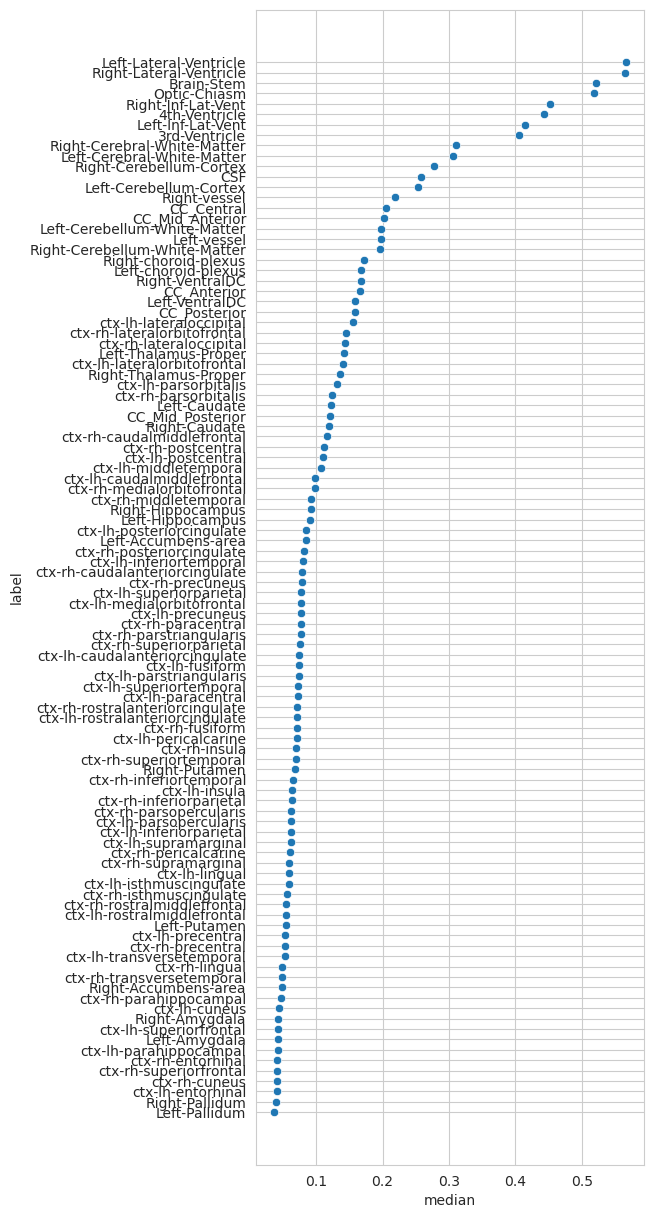

In [ ]:
# Sort the dataframe by the median column in descending order
class_contrasts_sorted = class_contrasts.sort_values(by='median', ascending=False).reset_index(drop=True)

# Set the figure size
fig, axs = plt.subplots(figsize=(5, 15))

# Create a point plot with error bars
sns.scatterplot(
    data=class_contrasts_sorted,
    x='median',
    y='label',
    palette='viridis',
    ax=axs
)

# Add error bars manually
for index, row in class_contrasts_sorted.iterrows():
    axs.errorbar(
        x=row['median'],
        y=index,
        xerr=[[row['median'] - row['ci5']], [row['ci95'] - row['median']]],
        fmt='none',
        c='black',
        capsize=3
    )

# Set labels and title
axs.set_xlabel('Weber Contrast')
axs.set_ylabel('')
axs.set_title('')
fig.tight_layout()


# save figure shown in plt

fig.savefig('/gpfs/home/kn2347/figs/weber_contrast_strip.pdf', dpi=300)

### Runtime Comparison

MedSAM: 130.77635069758284 +/- 40.882355201606934
MedSAM + YOLO: 145.5805885945453 +/- 73.39095750732702
MedSAM + Oracle: 97.22216899523548 +/- 31.498330558499916
UNet: 135.38020190338884 +/- 40.63352772873803


ValueError: unequal length arrays

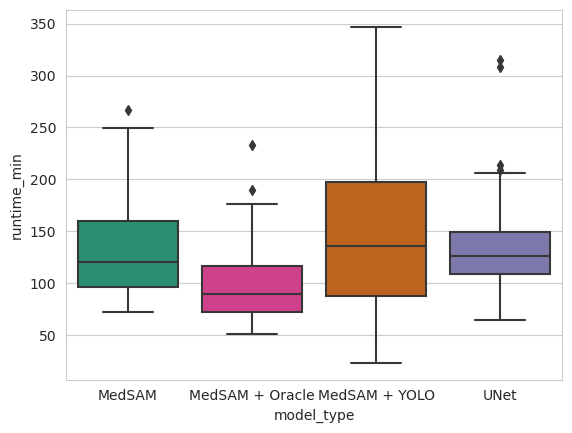

In [69]:
runtime_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_training_runtimes_12-30-24/training_runtimes.csv')
runtime_df['runtime_min'] = runtime_df['runtime']/60.0

# remove outliers
runtime_df = runtime_df[runtime_df['runtime_min'] < 500].reset_index(drop=True) # excluded is one outlier run (label 4) by UNet in which CPU was used instead of GPU
#runtime_df = runtime_df[runtime_df['label'] != 4].reset_index(drop=True)

# compute mean and standard deviation
sub1 = runtime_df[runtime_df['model_type'] == 'MedSAM']['runtime_min']
print(f'MedSAM: {np.mean(sub1)} +/- {np.std(sub1)}')

sub1 = runtime_df[runtime_df['model_type'] == 'MedSAM + YOLO']['runtime_min']
print(f'MedSAM + YOLO: {np.nanmean(sub1)} +/- {np.nanstd(sub1)}')

sub1 = runtime_df[runtime_df['model_type'] == 'MedSAM + Oracle']['runtime_min']
print(f'MedSAM + Oracle: {np.nanmean(sub1)} +/- {np.nanstd(sub1)}')

sub1 = runtime_df[runtime_df['model_type'] == 'UNet']['runtime_min']
print(f'UNet: {np.mean(sub1)} +/- {np.std(sub1)}')

# Create a boxplot
fig, axs = plt.subplots()
sns.boxplot(runtime_df, x = 'model_type', y='runtime_min', palette = my_colors, ax = axs)

# add statistical tests
annotator = Annotator(axs, 
    pairs = [
        ('MedSAM', 'UNet')
    ], 
    data=runtime_df, 
    x='model_type', 
    y='runtime', 
    order=['MedSAM', 'UNet']
)

annotator.configure(test='t-test_paired', text_format='star', loc='outside')
annotator.apply_and_annotate()  

axs.set_xlabel('Method')
axs.set_ylabel('Runtime (min)')

### SAM vs MedSAM fine-tuned

In [12]:
singletask_sam_finetuned = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/SAM_Finetune/test/*/0.0001/at_least_100_pixels/eval_singletask_unprompted_test_label*.pkl')
singletask_sam_yolo_finetuned = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/SAM_Finetune_YOLO/test/*/0.0001/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')

# fill in missing labels for singletask_sam_yolo_finetuned
dicto = {'dice_sensitivity':[np.nan]*4, 'dice_specificity':[1.0]*4, 'overall_dice':[np.nan]*4, 'label_number': [3,18,22,33]}
append_df = pd.DataFrame(dicto)
singletask_sam_yolo_finetuned = pd.concat([singletask_sam_yolo_finetuned, append_df], ignore_index=True)




p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SAM-YOLO vs. MedSAM-Constant: t-test paired samples, P_val:7.203e-01 t=3.591e-01
MedSAM-Constant vs. MedSAM-YOLO: t-test paired samples, P_val:5.278e-01 t=6.339e-01
SAM-Constant vs. MedSAM-Constant: t-test paired samples, P_val:8.554e-01 t=-1.827e-01


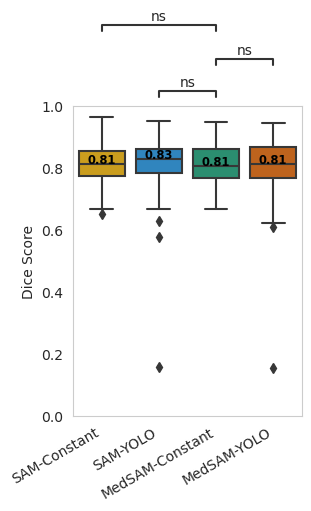

In [19]:
medsam_sam_dict = {'singletask_medsam': singletask_medsam, 
    'singletask_sam': singletask_sam_finetuned,
    'singletask_medsam_yolo': singletask_medsam_yolo,
    'singletask_sam_yolo': singletask_sam_yolo_finetuned
}

# apply some steps before merging the dataframes
medsam_sam_dict = rename_dfs(medsam_sam_dict)
medsam_sam_merged, medsam_sam_df_long = merge_dict_of_dfs(medsam_sam_dict)

# figure
fig, axs = plt.subplots(constrained_layout=True, figsize = (3,5))

medsam_sam_df_long['method'] = [mapper[x] for x in medsam_sam_df_long['method']]

# set order
order = ['SAM-Constant', 'SAM-YOLO', 'MedSAM-Constant', 'MedSAM-YOLO']
#order = ['SAM-Constant', 'MedSAM-Constant', 'MedSAM-YOLO']

# subset
subdf = medsam_sam_df_long[medsam_sam_df_long['method'].isin(order)].reset_index(drop=True)

# plot
box_plot = sns.boxplot(data = subdf,
            x = 'method',
            y = 'dice_score',
            order = order,
            palette = my_colors,
            ax = axs
)
#axs.tick_params(axis='x', labelrotation=45)
for label_txt in box_plot.get_xticklabels():
    label_txt.set_rotation(30)  
    label_txt.set_ha('right')


medians = subdf.groupby('method')['dice_score'].median().reindex(index = order)
vertical_offset = .005 * subdf['dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'%s' % str('%.2f' % medians[xtick]), 
            horizontalalignment='center',size='small',color='black',weight='semibold')
axs.grid(False)


axs.set_ylabel('Dice Score')
#axs.set_xlabel('Method')
axs.set_xlabel('')
# add statistical tests

annotator = Annotator(axs, 
    pairs = [
        (order[0], order[2]),
        (order[1], order[2]),
        (order[2], order[3])
    ], 
    data=subdf, 
    x='method', 
    y='dice_score', 
    order=order
)
axs.set_ylim(0,1)

annotator.configure(test='t-test_paired', text_format='star', loc='outside')
annotator.apply_and_annotate()  

fig.savefig('/gpfs/home/kn2347/figs/medsam_vs_sam_finetuned_boxplot.pdf', dpi=300)

### Non-finetuned comparison

In [32]:
# load and create combined df's

untuned_medsam_oracle = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_No_Finetune/test/*/No_Finetune/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')
untuned_medsam_yolo = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_No_Finetune_YOLO/test/*/No_Finetune/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')

untuned_sam_oracle = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/SAM_No_Finetune/test/*/No_Finetune/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')
untuned_sam_yolo = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/SAM_No_Finetune_YOLO/test/*/No_Finetune/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')

finetuned_medsam_oracle = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_Oracle/test/*/*/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')
finetuned_sam_oracle = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/SAM_Oracle/test/*/*/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')

# define df
untuned_dict = {'untuned_medsam_oracle': untuned_medsam_oracle, 
    'untuned_medsam_yolo': untuned_medsam_yolo, 
    'untuned_sam_oracle': untuned_sam_oracle,
    'untuned_sam_yolo': untuned_sam_yolo,
    'finetuned_medsam_oracle': finetuned_medsam_oracle,
    'finetuned_sam_oracle': finetuned_sam_oracle
}

# apply some steps before merging the dataframes
untuned_dict = rename_dfs(untuned_dict)
untuned_df_merged, untuned_df_long = merge_dict_of_dfs(untuned_dict)

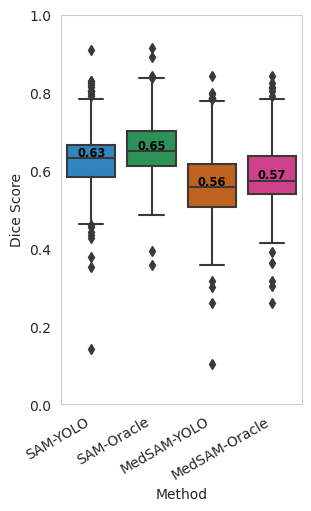

In [56]:
order = ['SAM-YOLO', 'SAM-Oracle', 'MedSAM-YOLO', 'MedSAM-Oracle']
#untuned_palette = dict(zip(order, [palette[4], palette[5], palette[6], palette[7], palette[3]]))
untuned_palette = dict(zip(order, [my_colors[x] for x in order]))
# boxplot
tmp_df = untuned_df_long.copy()

# figure
fig, axs = plt.subplots(constrained_layout=True, figsize = (3,5))

# make method names more readable
mapper = {
    'untuned_medsam_oracle': 'MedSAM-Oracle', 
    'untuned_medsam_yolo': 'MedSAM-YOLO', 
    'untuned_sam_oracle': 'SAM-Oracle',
    'untuned_sam_yolo': 'SAM-YOLO',
    'finetuned_medsam_oracle': 'Fine-tuned MedSAM-Oracle'
}
tmp_df['method'] = [mapper[x] for x in tmp_df['method']]

# set order

# plot
box_plot = sns.boxplot(data = tmp_df,
            x = 'method',
            y = 'dice_score',
            order = order,
            palette = untuned_palette,
            ax = axs
)
#axs.tick_params(axis='x', labelrotation=45)
for label_txt in box_plot.get_xticklabels():
    label_txt.set_rotation(30)  
    label_txt.set_ha('right')


medians = tmp_df.groupby('method')['dice_score'].median().reindex(index = order)
vertical_offset = .01 * tmp_df['dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'%s' % str('%.2f' % medians[xtick]), 
            horizontalalignment='center',size='small',color='black',weight='semibold')
axs.grid(False)


axs.set_ylabel('Dice Score')
axs.set_xlabel('Method')

# add statistical tests
annotator = Annotator(axs, 
    pairs = [
        (order[0], order[2]),
        (order[1], order[3])
    ], 
    data=tmp_df, 
    x='method', 
    y='dice_score', 
    order=order
)
axs.set_ylim(0,1)

annotator.configure(test='t-test_paired', text_format='star', loc='outside')
#annotator.apply_and_annotate()  

fig.savefig('/gpfs/home/kn2347/figs/untuned_analysis_boxplot.pdf', dpi=300)

In [11]:
# plot untuned-SAM Oracle versus tuned-SAM Oracle and see which regions the difference is most pronounced

# define df
untuned_vs_tuned_dict = {'untuned_sam_oracle': untuned_sam_oracle, 
    'finetuned_sam_oracle': finetuned_sam_oracle
}

# apply some steps before merging the dataframes
untuned_vs_tuned_dict = rename_dfs(untuned_vs_tuned_dict)
untuned_vs_tuned_df_merged, untuned_vs_tuned_df_long = merge_dict_of_dfs(untuned_vs_tuned_dict)

#order_descending = untuned_vs_tuned_df_long.dropna(how='all').groupby('label_number').agg({'dice_score':'median'}).sort_values('dice_score', ascending=False).dropna().index.astype(int).tolist()

# order sorted by dice score of the untuned model
order_descending = untuned_vs_tuned_df_long[untuned_vs_tuned_df_long['method'] == 'untuned_sam_oracle'].sort_values('dice_score', ascending=False)['label_number']
order_descending = [label_converter.compressed_to_name(x).item() for x in order_descending]

In [13]:
untuned_vs_tuned_df_merged

,label_number,dice_sensitivity_untuned_sam_oracle,dice_specificity_untuned_sam_oracle,overall_dice_untuned_sam_oracle,dice_sensitivity_finetuned_sam_oracle,dice_specificity_finetuned_sam_oracle,overall_dice_finetuned_sam_oracle
0,1.0,0.487240,1.0,0.791555,0.924023,1.0,0.969114
1,2.0,0.713245,1.0,0.975049,0.926832,1.0,0.993634
2,3.0,NaN,1.0,1.000000,NaN,1.0,1.000000
3,4.0,0.586401,1.0,0.957739,0.877397,1.0,0.987473
4,5.0,0.804953,1.0,0.959235,0.917811,1.0,0.982822
...,...,...,...,...,...,...,...
97,98.0,0.551102,1.0,0.917220,0.845175,1.0,0.971449
98,99.0,0.638655,1.0,0.936485,0.876368,1.0,0.978269
99,100.0,0.675108,1.0,0.953244,0.863042,1.0,0.980290
100,101.0,0.703319,1.0,0.996570,0.876780,1.0,0.998576


In [12]:
cpy = untuned_vs_tuned_df_merged.copy()
cpy['delta'] = cpy['dice_sensitivity_finetuned_sam_oracle'] - cpy['dice_sensitivity_untuned_sam_oracle']
cpy = cpy.sort_values('delta', ascending=False)
cpy['label_number'] = [label_converter.compressed_to_name(x) for x in cpy['label_number']]
#print(cpy.head(10))
print(cpy.tail(20))

              label_number  dice_sensitivity_untuned_sam_oracle  \
11              Brain-Stem                             0.838642   
4   Left-Cerebellum-Cortex                             0.804953   
13           Left-Amygdala                             0.813227   
25           Right-Caudate                             0.843453   
26           Right-Putamen                             0.827513   
15     Left-Accumbens-area                             0.811988   
12        Left-Hippocampus                             0.826216   
28       Right-Hippocampus                             0.835988   
29          Right-Amygdala                             0.837135   
9            3rd-Ventricle                             0.892433   
10           4th-Ventricle                             0.915749   
2        Left-Inf-Lat-Vent                                  NaN   
17             Left-vessel                                  NaN   
21      Right-Inf-Lat-Vent                                  Na

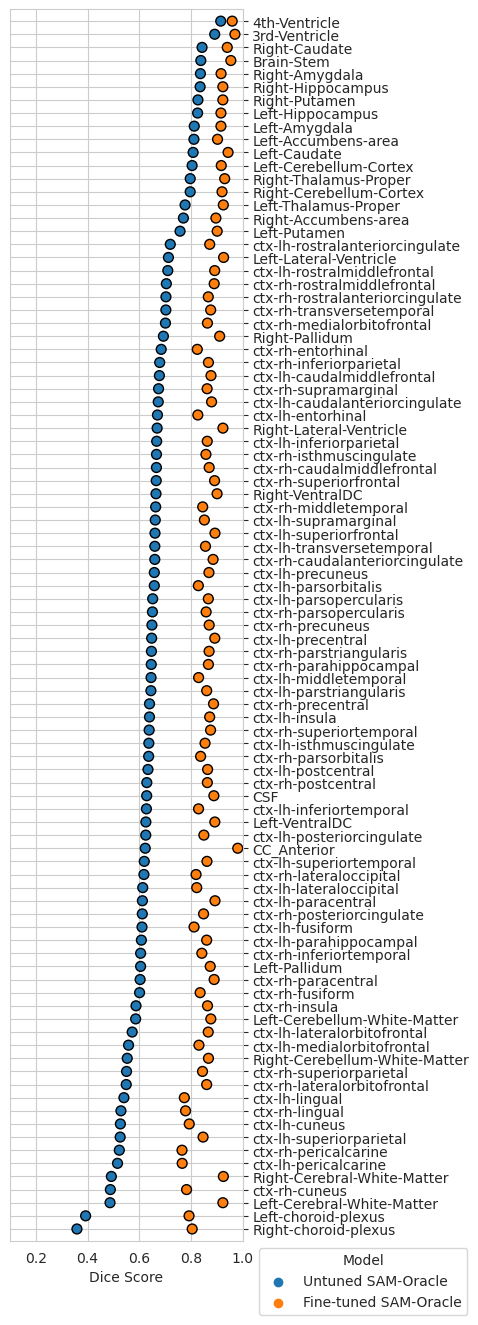

In [13]:
groups = 1
tot = 102
per = math.ceil(tot / groups)
fig, axs = plt.subplots(figsize = (3, 16))

#mapper = {'singletask_medsam_oracle': 'Fine-tuned MedSAM + Oracle', 'untuned_medsam_oracle': 'Untuned MedSAM + Oracle'}
mapper = {'untuned_sam_oracle': 'Untuned SAM-Oracle', 'finetuned_sam_oracle': 'Fine-tuned SAM-Oracle'}
for idx in range(groups):
    idx_L = per * (idx)
    idx_R = per * (idx+1) - 1

    sub2 = untuned_vs_tuned_df_long.copy() 
    sub2['label_number'] = [label_converter.compressed_to_name(x).item() for x in sub2['label_number']]
    sub2 = sub2.set_index('label_number').loc[order_descending[idx_L:idx_R],:].reset_index(drop=False)
    sub2['method'] = [mapper[x] for x in sub2['method']]
    sub2['label_number'] = pd.Categorical(sub2['label_number'], categories=order_descending[idx_L:idx_R], ordered=True)
    #sub2 = sub2[sub2['label_number'].isin(order_descending[idx_L : idx_R])]
    
    

    
    #fig, axs = plt.subplots(constrained_layout=True, figsize = (4 * 4 / groups, 3))
    
    #sub2 = sub2[sub2['label_number'] <= 5]
    sub2 = sub2.dropna(axis=0, how='any')
    _ = sns.scatterplot(sub2, x='dice_score', y='label_number', hue='method', ax = axs, 
        s=50, edgecolor = 'black', linewidth=1, marker='o', alpha=1)

    axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), ha='left')
    axs.yaxis.set_label_position("right")
    axs.yaxis.tick_right()
    axs.set_xlabel('Dice Score')
    axs.set_ylabel('')
    axs.margins(y=0.01) 
    axs.set_xlim(0.1, 1.0)
    plt.legend(bbox_to_anchor=(1.04, 0), loc="upper left", title='Model')


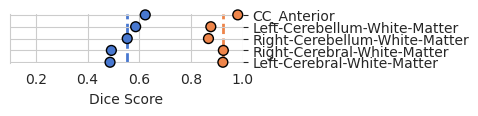

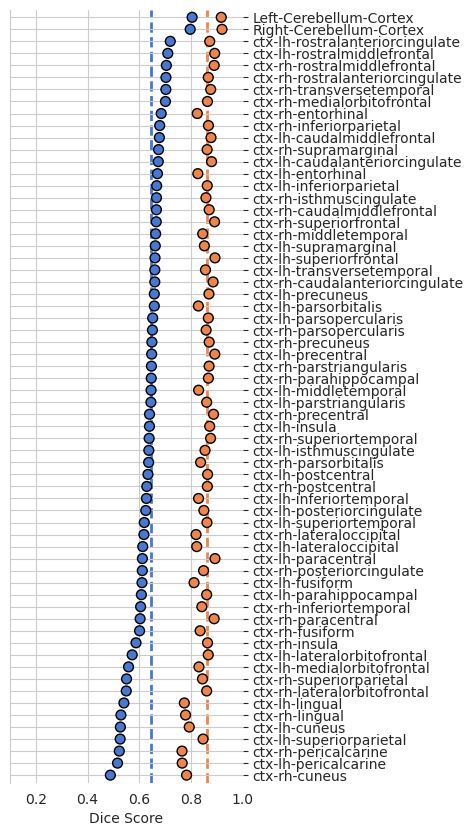

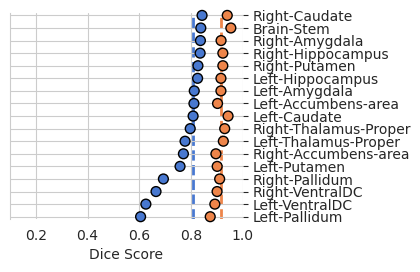

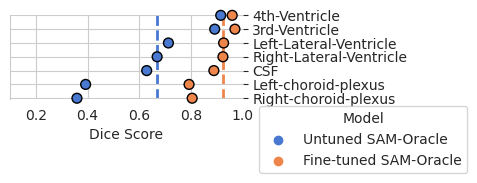

In [17]:
mapper = {'finetuned_sam_oracle': 'Fine-tuned SAM-Oracle', 'untuned_sam_oracle': 'Untuned SAM-Oracle'}
this_pal_untuned = sns.color_palette("muted", 2)
color_dict_untuned = {'Untuned SAM-Oracle': this_pal_untuned[0], 'Fine-tuned SAM-Oracle': this_pal_untuned[1]}


for ii, grp in enumerate(groups):

    sub2 = untuned_vs_tuned_df_long.copy() 
    sub2['label_number'] = [label_converter.compressed_to_name(x).item() for x in sub2['label_number']]
    sub2 = sub2[sub2['label_number'].isin(grp)]

    order_descending_for_this_group = [x for x in order_descending if x in grp]
    sub2 = sub2.set_index('label_number').loc[order_descending_for_this_group,:].reset_index(drop=False)

    
    num = len(sub2)
    if ii == 0:
        num = 4 * 2
    elif ii==3:
        num = 7 * 2

    fig, axs = plt.subplots(figsize = (3, 16*num/102/2))

    sub2['method'] = [mapper[x] for x in sub2['method']]
    sub2['label_number'] = pd.Categorical(sub2['label_number'], categories=order_descending_for_this_group, ordered=True)

    if(len(sub2) > 4):
        method_medians = sub2.groupby('method').agg({'dice_score':'median'})
        for r in method_medians.iterrows():
            # add vertical line with value equal to this dice score, and hue equal to the method indexed in my_colors
            axs.axvline(x = r[1].values[0], color = color_dict_untuned[r[0]], linestyle = '--', alpha = 1, linewidth=2, zorder=0)

    #fig, axs = plt.subplots(constrained_layout=True, figsize = (4 * 4 / groups, 3))
    
    #sub2 = sub2[sub2['label_number'] <= 5]
    sub2 = sub2.dropna(axis=0, how='any')
    _ = sns.scatterplot(sub2, x='dice_score', y='label_number', hue='method', ax = axs, 
        s=50, edgecolor = 'black', linewidth=1, marker='o', alpha=1, clip_on=False, palette=color_dict_untuned, legend=None if ii < 3 else True)

    axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), ha='left')
    axs.yaxis.set_label_position("right")
    axs.yaxis.tick_right()
    axs.set_xlabel('Dice Score')
    axs.set_ylabel('')
    axs.spines[['right', 'top', 'bottom']].set_visible(False)
    axs.margins(y=0.01)
    axs.set_xlim(0.1, 1.0)

    if ii == 3:
        plt.legend(bbox_to_anchor=(1.04, 0), loc="upper left", title='Model')

    fig.savefig(f'/gpfs/home/kn2347/figs/untuned_strip_plot_components/{ii}.pdf', dpi=300, bbox_inches = 'tight')


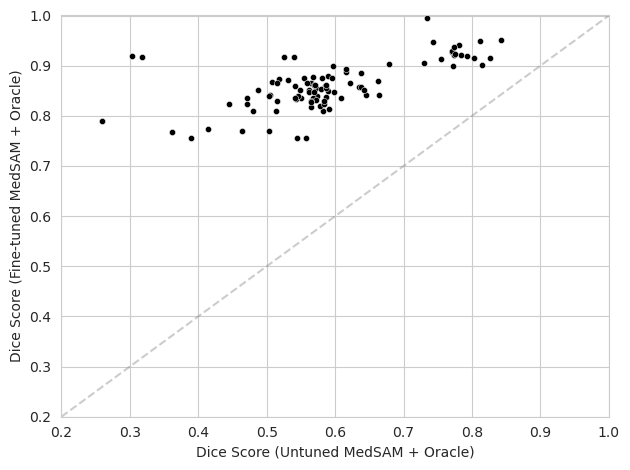

In [13]:
fig, axs = plt.subplots()
sns.scatterplot(untuned_vs_tuned_df_merged, x='dice_sensitivity_untuned_medsam_oracle', y='dice_sensitivity_singletask_medsam_oracle', s=20, color='black', ax = axs)
axs.set_xlim(0.2,1)
axs.set_ylim(0.2,1)
axs.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
axs.set_xlabel('Dice Score (Untuned MedSAM + Oracle)')
axs.set_ylabel('Dice Score (Fine-tuned MedSAM + Oracle)')
fig.tight_layout()

In [14]:
untuned_vs_tuned_df_merged['residual'] = untuned_vs_tuned_df_merged['dice_sensitivity_singletask_medsam_oracle'] - untuned_vs_tuned_df_merged['dice_sensitivity_untuned_medsam_oracle']


dfdf = untuned_vs_tuned_df_merged[['label_number', 'residual']].copy()
dfdf['label_number'] = dfdf['label_number'].astype(int)

class_stats = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/training_set_class_statistics_10-15-24/class_statistics.csv')
class_stats = class_stats.rename({'label': 'label_number'}, axis=1)
dfdf = dfdf.merge(class_stats, how='left', on='label_number')

class_contrasts = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/class_contrasts_12-30-24/using_50_mris.csv')
class_contrasts = class_contrasts.rename({'label': 'label_number'}, axis=1)
dfdf = dfdf.merge(class_contrasts, how='left', on='label_number')
dfdf
#dfdf['label_number'] = [label_converter.compressed_to_name(x).item() for x in dfdf['label_number']]

# regress residual against all other columns
dfdf.corr()['residual']

label_number                         0.173923
residual                             1.000000
total_slices                         0.248784
total_pixels                         0.154998
avg_pixels_per_slice_when_present    0.115455
avg_pixels_per_all_slices            0.154998
fraction_slices_present              0.248784
median                               0.242978
ci5                                  0.335637
ci95                                 0.161832
Name: residual, dtype: float64

<Axes: xlabel='total_slices', ylabel='residual'>

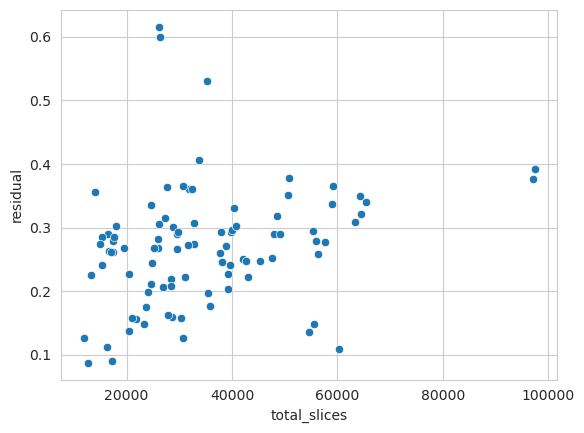

In [24]:
dfdf['contrast_binarized'] = dfdf['median'] >= np.quantile(dfdf['median'], 0.5)
dfdf['number_of_slices_binarized'] = dfdf['total_slices'] >= np.quantile(dfdf['total_slices'], 0.5)

sns.scatterplot(dfdf, x='total_slices', y='residual')


## Subset Analysis

In [20]:
def collect_df_repeat(pattern):
    listo = glob(pattern)

    collector = {'label_number': [], 'pct_dataset': [], 'repeat': [], 'dice_sensitivity': [], 'dice_specificity': [], 'overall_dice': []}
    for x in listo:
        label = int(x.split('/')[-5])
        frac = int(x.split('/')[-4])
        repeat = int(x.split('/')[-3])
        #this_pkl = torch.load(x, map_location=torch.device('cpu'))
        with open(x, 'rb') as file:
            this_pkl = CPU_Unpickler(file).load()

        collector['label_number'].append(label)
        collector['pct_dataset'].append(frac)
        collector['repeat'].append(repeat)
        collector['dice_sensitivity'].append(this_pkl['dice_sensitivity'].item())
        collector['dice_specificity'].append(this_pkl['dice_specificity'].item())
        collector['overall_dice'].append(this_pkl['overall_dice'].item())


    total_df = pd.DataFrame(collector)
    total_df = total_df.sort_values(by = ['label_number', 'pct_dataset', 'repeat']).reset_index(drop=True)
    return total_df


#pattern1 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/UNet/val/0.0005/*/*/*/at_least_100/eval_singletask_unet_val_label*.pkl'
pattern1 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/UNet/test/0.0005/*/*/*/at_least_100/*.pkl'
unet_df = collect_df_repeat(pattern1)
unet_df['model'] = 'UNet'

#pattern2 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM/val/0.0005/*/*/*/at_least_100/eval_singletask_unprompted_val_label*.pkl'
#pattern2 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM/test/0.0005/*/*/*/at_least_100/*.pkl'
pattern2 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_12-21-24/MedSAM/test/0.0005/*/*/*/at_least_100/*.pkl'
medsam_df = collect_df_repeat(pattern2)
medsam_df['model'] = 'MedSAM-Constant'

#pattern3 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM_Oracle/test/0.0005/*/*/*/at_least_100/eval_singletask_yolov7_prompted_test_label*.pkl'
pattern3 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_12-21-24/MedSAM_Oracle/test/0.0005/*/*/*/at_least_100/*.pkl'
medsam_oracle_df = collect_df_repeat(pattern3)
medsam_oracle_df['model'] = 'MedSAM-Oracle'

pattern4 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_12-21-24/SAM_Oracle_Noised/test/0.0001/*/*/*/at_least_100/*.pkl'
sam_oracle_df = collect_df_repeat(pattern4)
sam_oracle_df['model'] = 'SAM-Oracle'

total_df = pd.concat([medsam_df, medsam_oracle_df, unet_df, sam_oracle_df], ignore_index=True)
total_df = total_df[total_df['label_number'].isin([1, 7, 71])].reset_index(drop=True)

#total_df = total_df[total_df['model'].isin(['MedSAM-Constant', 'UNet'])]

In [21]:
def plot_repeats(label):
    # plot each repeat

    # for given number_mris:
    # dice_sensitivity vs repeat, with hue showing model type (UNet or MedSAM or MedSAM_oracle)
    r = 4
    c = 4
    fig, axs = plt.subplots(r,c, layout='constrained', sharex=True, sharey=True, squeeze=False, figsize = (10, 10))
    labels = [label]

    #filtered_df = total_df[total_df['dice_sensitivity'] >= 0.01]
    filtered_df = total_df
    label_mapper = {1: 'Left Cerebral White Matter', 71: 'Left Insula', 7: 'Left Caudate'}

    dataset_sizes = [1, 2, 3, 4, 5, 7, 10, 15, 20, 50, 100, 250, 500, 891]
    #g = sns.FacetGrid(total_df, col = 'label_number', hue = 'model', col_wrap=4)
    lab = labels[0]
    for idx in range(len(dataset_sizes)):
        i = idx // c
        j = idx % c
        subdf = filtered_df[(filtered_df['label_number'] == lab) & (filtered_df['pct_dataset'] == dataset_sizes[idx]) ]
        
        xx = sns.lineplot(subdf, x='repeat', y='dice_sensitivity', hue='model', marker='o', ax=axs[i,j], legend = True if (i,j) == (0,0) else False, palette=my_colors)

        axs[i,j].set_xlabel('Repeat')
        axs[i,j].set_ylabel('Test Dice Score')
        axs[i,j].set_title(f'Size = {dataset_sizes[idx]}, Label = {lab}')

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="outside upper center", ncol=2)
    axs[0,0].get_legend().remove()


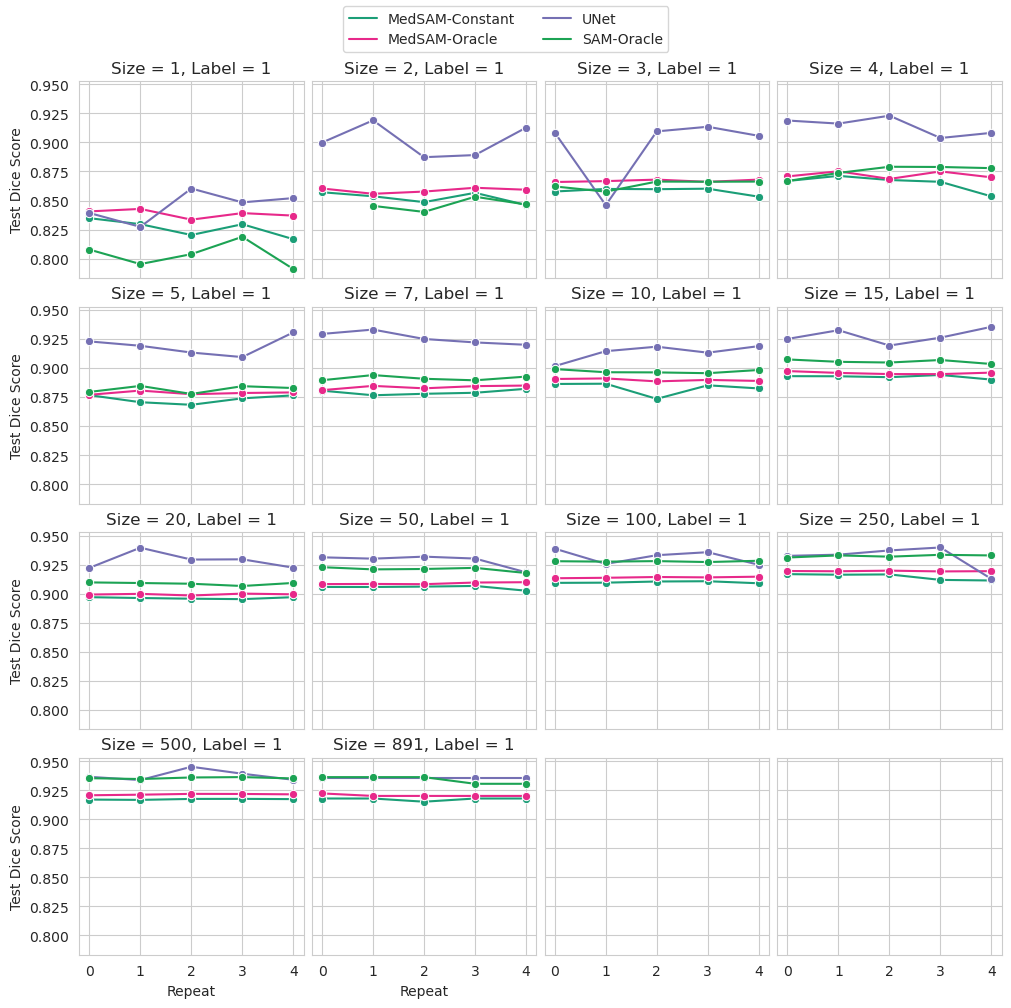

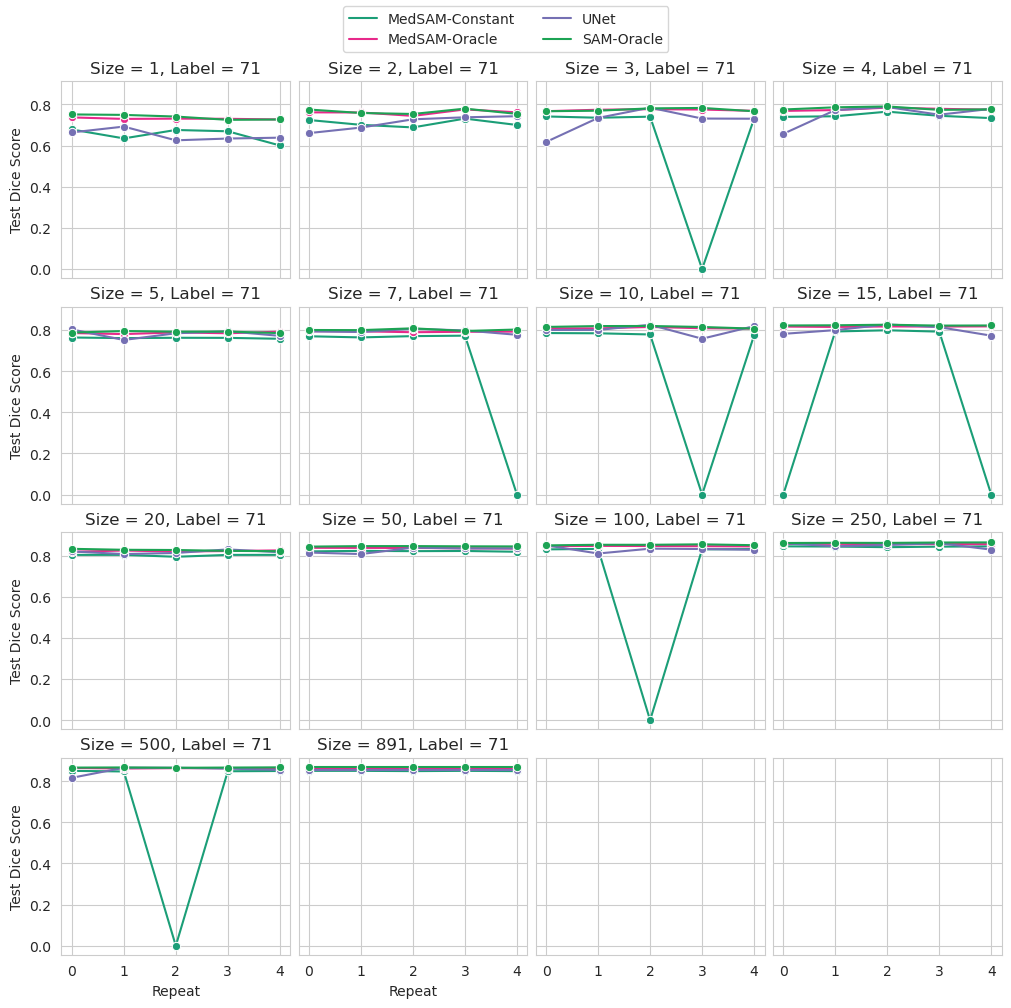

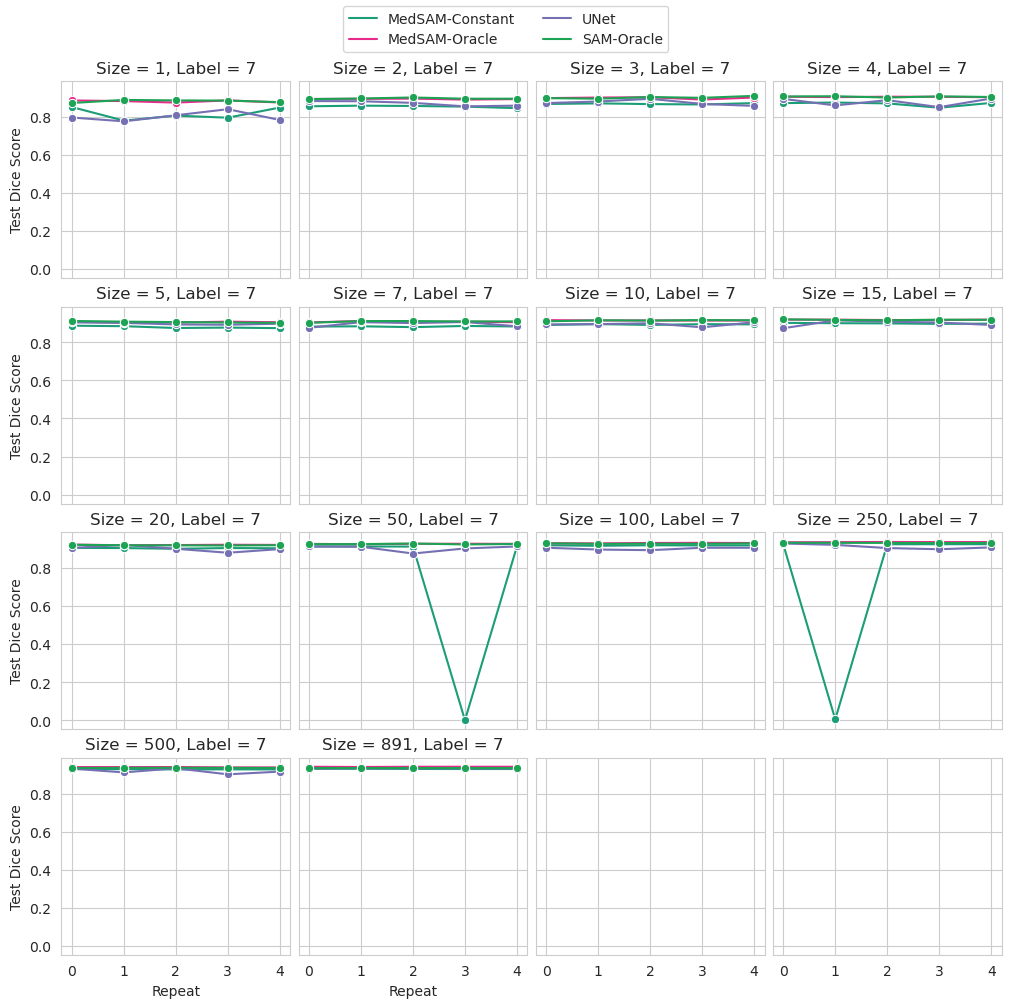

In [11]:
plot_repeats(1)
plot_repeats(71)
plot_repeats(7)

In [23]:
# filter out the outlier repeats by removing repeats that have dice score lower than median_for_that_(label, pct_dataset, model)_tuple - 0.30 (i.e. if the median is 0.8, then any repeats with lower than 0.5 would be dropped)

filtered_df = total_df.copy()
zz = filtered_df.groupby(['label_number', 'pct_dataset', 'model']).agg(
    {
        'dice_sensitivity': lambda x: np.quantile(x,0.5) - 0.30
    }
).reset_index(drop=False)

filtered_df = filtered_df.merge(zz, how='left', on=['label_number', 'pct_dataset', 'model'], suffixes=['','_threshold'])

print('runs filtered out:')
print(filtered_df[filtered_df['dice_sensitivity'] < filtered_df['dice_sensitivity_threshold']])

filtered_df = filtered_df[filtered_df['dice_sensitivity'] >= filtered_df['dice_sensitivity_threshold']]
filtered_df = filtered_df.reset_index(drop=True)

# generate median df
median_df = filtered_df.groupby(['label_number', 'pct_dataset', 'model']).agg({'dice_sensitivity': 'median'}).reset_index(drop=False)

runs filtered out:
     label_number  pct_dataset  repeat  dice_sensitivity  dice_specificity  \
118             7           50       3      6.752711e-09      1.000000e+00   
126             7          250       1      4.616135e-03      1.525879e-11   
153            71            3       3      5.356773e-09      1.000000e+00   
169            71            7       4      5.356773e-09      1.000000e+00   
173            71           10       3      5.356773e-09      1.000000e+00   
175            71           15       0      5.356773e-09      1.000000e+00   
179            71           15       4      5.356773e-09      1.000000e+00   
192            71          100       2      5.356773e-09      1.000000e+00   
202            71          500       2      5.356773e-09      1.000000e+00   

     overall_dice            model  dice_sensitivity_threshold  
118      0.906570  MedSAM-Constant                    0.613043  
126      0.000431  MedSAM-Constant                    0.624464  
153  

In [24]:
# get dice scores of medsam-constant for label 7 at the subset=891 and for all the repeats
medsam_df[(medsam_df['label_number'] == 71) & (medsam_df['pct_dataset'] == 891)]['dice_sensitivity']

205    0.850297
206    0.850297
207    0.848932
208    0.850297
209    0.848932
Name: dice_sensitivity, dtype: float64

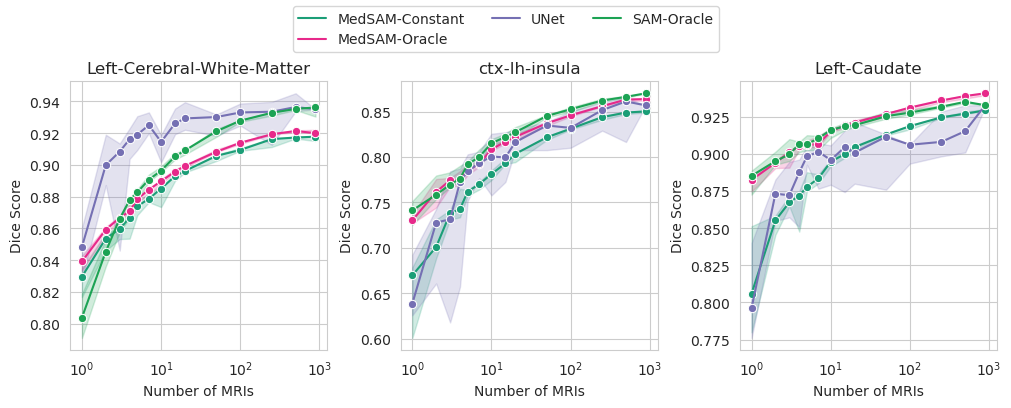

In [25]:
r = 1
c = 3
fig, axs = plt.subplots(r,c, layout='constrained', sharex=True, squeeze=False,  figsize = (10, 4))
labels = [1,71,7]

#g = sns.FacetGrid(total_df, col = 'label_number', hue = 'model', col_wrap=4)
for idx, lab in enumerate(labels):
    i = idx // c
    j = idx % c
    
    xx = sns.lineplot(filtered_df[filtered_df['label_number'] == lab], x = 'pct_dataset', y = 'dice_sensitivity', hue = 'model', marker='o', ax = axs[i,j],
        estimator='median', legend = True if (i,j) == (0,0) else False, err_style='band', errorbar=('ci', 95),
        palette = my_colors)
    axs[i,j].set_xscale('log')
    axs[i,j].set_xlabel('Number of MRIs')
    axs[i,j].set_ylabel('Dice Score')
    axs[i,j].set_title(f'{label_converter.compressed_to_name(lab)}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside upper center", ncol=3)
axs[0,0].get_legend().remove()

#fig.savefig('/gpfs/home/kn2347/figs/subset_analysis_test.pdf', dpi=300)

In [50]:
untuned_medsam_oracle_2 = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_No_Finetune/test/*/No_Finetune/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')
# get dice_sensitivity for label 'label'
untuned_medsam_oracle_2[untuned_medsam_oracle_2['label_number'] == 7]['dice_sensitivity'].item()

0.7804242968559265

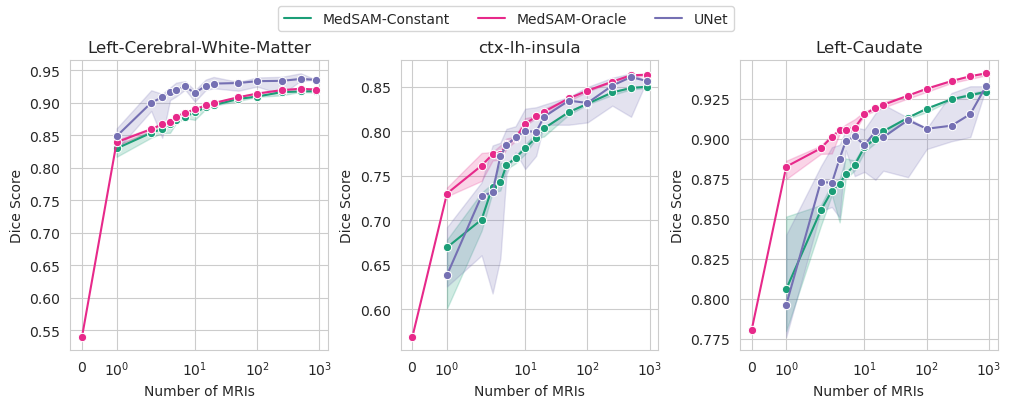

In [67]:

# make another version of this plot, but add in number_of_mris=0

# load in the untuned oracle data
untuned_medsam_oracle_2 = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_analysis_12-18-24/MedSAM_No_Finetune/test/*/No_Finetune/at_least_100_pixels/eval_singletask_yolov7_prompted_test_label*.pkl')


r = 1
c = 3
fig, axs = plt.subplots(r,c, layout='constrained', sharex=True, squeeze=False,  figsize = (10, 4))
labels = [1,71,7]

#g = sns.FacetGrid(total_df, col = 'label_number', hue = 'model', col_wrap=4)
for idx, lab in enumerate(labels):
    i = idx // c
    j = idx % c
    
    filtered_df_copy = filtered_df.copy()
    this_label_dice_sens = untuned_medsam_oracle_2[untuned_medsam_oracle_2['label_number'] == lab]['dice_sensitivity'].item()
    #mini_df = pd.DataFrame({'label_number': [lab]*5, 'repeat': list(range(5)), 'pct_dataset': [0]*5, 'model': ['MedSAM-Oracle']*5, 'dice_sensitivity': [this_label_dice_sens]*5})
    mini_df = pd.DataFrame({'label_number': [lab], 'repeat': [0], 'pct_dataset': [0], 'model': ['MedSAM-Oracle'], 'dice_sensitivity': [this_label_dice_sens]})

    filtered_df_with_zero_added = pd.concat([filtered_df_copy, mini_df], ignore_index=True)

    xx = sns.lineplot(filtered_df_with_zero_added[filtered_df_with_zero_added['label_number'] == lab], x = 'pct_dataset', y = 'dice_sensitivity', hue = 'model', marker='o', ax = axs[i,j],
        estimator='median', legend = True if (i,j) == (0,0) else False, err_style='band', errorbar=('ci', 95),
        palette = my_colors)
    axs[i,j].set_xscale('symlog')
    axs[i,j].set_xlabel('Number of MRIs')
    axs[i,j].set_ylabel('Dice Score')
    axs[i,j].set_title(f'{label_converter.compressed_to_name(lab)}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside upper center", ncol=3)
axs[0,0].get_legend().remove()